In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import AUTOTUNE
from tensorflow import keras
from tensorflow.keras import layers
import json

c:\Users\Nagy Antal\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


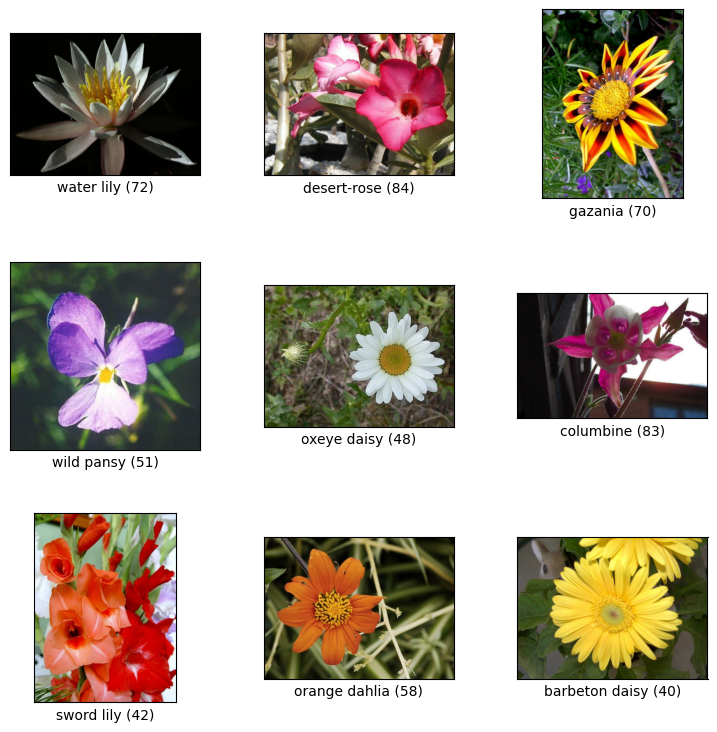

In [3]:
(train,test,valid),info = tfds.load(
        'oxford_flowers102',
        as_supervised=True,
        split=['train','test','validation'],
        with_info=True,
        data_dir='./datasets',
        shuffle_files=True
    )

fig = tfds.show_examples(train,info)

In [4]:
labels = [ item.strip() for item in open('./datasets/oxford_flowers102/2.1.1/label.labels.txt','r').readlines() ]
num_of_labels = len(labels)

num_training_examples = 0
num_validation_examples = 0
num_test_examples = 0

for example in train:
  num_training_examples += 1

for example in valid:
  num_validation_examples += 1

for example in test:
  num_test_examples += 1

In [5]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

def augment(image, label):
  new_width = new_height = 224
  image = tf.image.resize(image, (new_width, new_height))/255.0
  return image, label

BATCH_SIZE = 32
train_batches = train.cache().shuffle(num_training_examples//4).map(augment).batch(BATCH_SIZE).prefetch(1)


validation_batches = valid.cache().map(augment).batch(BATCH_SIZE).prefetch(1)

test_batches = test.cache().map(augment).batch(BATCH_SIZE).prefetch(1)

Előtte: tf.Tensor(1020, shape=(), dtype=int64)
Utána: tf.Tensor(32, shape=(), dtype=int64)


### TensorBoard Beállítása

In [7]:
from tensorflow.keras.callbacks import TensorBoard
import time

NAME = "oxfordflower_BiT_{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir=f'logs/{NAME}',
                          histogram_freq=1,
                          write_graph=True)


### Modell Elkészítése

In [8]:
import tensorflow_hub as hub

URL = "https://tfhub.dev/google/experts/bit/r50x1/in21k/plant/1"
feature_extractor = hub.KerasLayer(URL,input_shape=(224, 224, 3), trainable=False)

model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(info.features['label'].num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(train_batches, epochs=8, verbose=1, callbacks=[tensorboard])

Epoch 1/8


c:\Users\Nagy Antal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 178s 5s/step - loss: 4.8331 - accuracy: 0.3235
Epoch 2/8
32/32 [==============================] - 149s 5s/step - loss: 0.1314 - accuracy: 0.9657
Epoch 3/8
32/32 [==============================] - 145s 5s/step - loss: 0.0178 - accuracy: 0.9961
Epoch 4/8
32/32 [==============================] - 144s 4s/step - loss: 0.0034 - accuracy: 1.0000
Epoch 5/8
32/32 [==============================] - 145s 5s/step - loss: 0.0022 - accuracy: 1.0000
Epoch 6/8
32/32 [==============================] - 144s 4s/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/8
32/32 [==============================] - 144s 5s/step - loss: 0.0016 - accuracy: 1.0000
Epoch 8/8
32/32 [==============================] - 143s 4s/step - loss: 0.0014 - accuracy: 1.0000


Evaluate on test data
32/32 [==============================] - 150s 5s/step - loss: 0.1365 - accuracy: 0.9686
test loss, test acc: [0.13652737438678741, 0.9686274528503418]
1/1 [==============================] - 6s 6s/step
TESTER:  grape hyacinth
PREDICT:  grape hyacinth


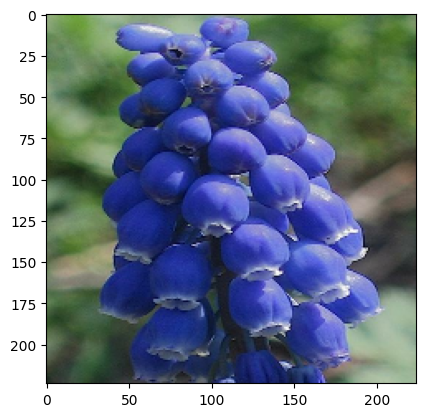

In [9]:
test = valid.cache().shuffle(num_training_examples//4).map(augment).batch(BATCH_SIZE).prefetch(1)

print("Evaluate on test data")
results = model.evaluate(test)
print("test loss, test acc:", results)

img, label = next(iter(train_batches.take(1)))
res = tf.argmax(model.predict(img.numpy()), axis=1)
print("TESTER: ",labels[int(res[0])])
print("PREDICT: ", labels[int(label[0])])
plt.imshow(img[0])

### Modell Mentése

- TensorFlow Model osztályából kell használni a .save metódust
- Így a KerasLayer megmarad

In [16]:
model.save('./models/BOARDED_'+NAME)

INFO:tensorflow:Assets written to: ./models/BOARDED_oxfordflower_BiT_1683555554\assets


INFO:tensorflow:Assets written to: ./models/BOARDED_oxfordflower_BiT_1683555554\assets


### Modell Betöltése
- Kész modell betöltése
- Tesztek futtatása
- Tesztek vizualizációja

` custom_objects={'KerasLayer': hub.KerasLayer} ` - 'hub.KerasLayer' betöltését engedélyezi

In [17]:
model = tf.keras.models.load_model(
  "models\BOARDED_oxfordflower_BiT_1683555554",
  custom_objects={'KerasLayer': hub.KerasLayer})

### Betöltött Modell Tesztelése
- Zöld a jó
- Piros a rossz

1/1 [==============================] - 7s 7s/step


<Figure size 1000x900 with 0 Axes>

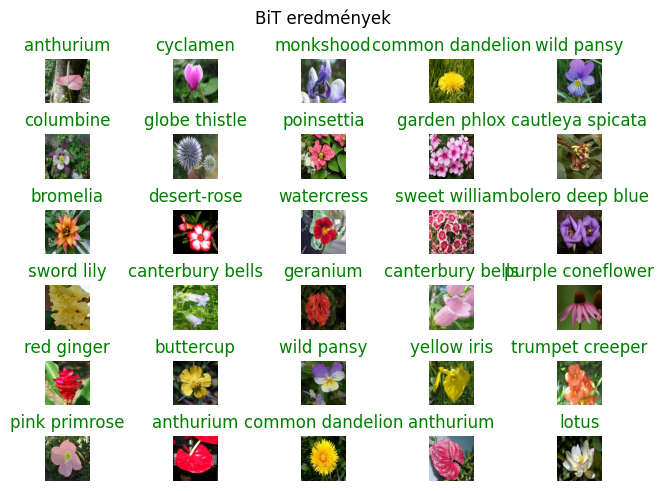

In [58]:
### Predict-hez adatok előkészítése ###
test = valid.cache().shuffle(num_training_examples//4).map(augment).batch(30).prefetch(1)
img, label = next(iter(test.take(1)))
tmp = model.predict(img.numpy())
res = tf.argmax(tmp, axis=1)

plt.figure(figsize=(10,9))
plt.subplots(6,5, constrained_layout=True)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(img[n])
    color = "green" if res[n] == label[n] else "red"
    plt.title(labels[label[n]], color=color)
    plt.axis('off')
    _ = plt.suptitle("BiT eredmények")